In [67]:
import pandas as pd
from rdkit import Chem
import seaborn as sns
from rdkit.Chem import QED, Draw, Descriptors, rdDepictor, rdMolDescriptors
from rdkit.Chem.FilterCatalog import FilterCatalogParams, FilterCatalog
from tqdm import tqdm
import matplotlib.pyplot as plt
rdDepictor.SetPreferCoordGen(True)
from rdkit.Contrib.SA_Score import sascorer

<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:488: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


In [69]:
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
catalog = FilterCatalog(params)

def calculate_brenk_relative(mol):
    num_alerts = len(catalog.GetMatches(mol))
    num_fragments = mol.GetNumAtoms()

    if num_fragments == 0:
        return 0
    return num_alerts / num_fragments

In [99]:
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem

def smiles_to_pdbqt(smiles: str, output_file: str = "legant.pdbqt"):
    """Конвертирует SMILES в PDBQT через Open Babel."""
    # Создание молекулы из SMILES и добавление водородов
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    status = AllChem.EmbedMolecule(mol)
    if status == -1:
        raise RuntimeError("Не удалось сгенерировать 3D-структуру")
    
    # Сохранение во временный файл .mol
    temp_mol = "temp.mol"
    Chem.MolToMolFile(mol, temp_mol)
    if not os.path.exists(temp_mol):
        raise FileNotFoundError("Временный файл не создан")
    
    # Конвертация в PDBQT через Open Babel
    cmd = f"obabel temp.mol -O legant.pdbqt --gen3d"
    result = subprocess.run(
        cmd, 
        shell=True, 
        capture_output=True, 
        text=True
    )

    if result.returncode != 0:
        error_msg = f"Ошибка Open Babel:\n{result.stderr}"
        if "Invalid output format" in result.stderr:
            error_msg += "\nУбедитесь, что Open Babel установлен и добавлен в PATH"
        raise RuntimeError(error_msg)

    if not os.path.exists(output_file):
            raise FileNotFoundError(f"Файл {output_file} не создан")
    
    os.remove(temp_mol)

def run_vina_docking(protein_pdbqt: str, ligand_pdbqt: str, center: tuple = (27.116, 24.090, 14.936), size: tuple = (10, 10, 10)) -> float:
    """Запускает докинг и возвращает энергию связывания."""
    # Создание конфигурационного файла для Vina
    config = f"""
    receptor = {protein_pdbqt}
    ligand = {ligand_pdbqt}
    out = result.pdbqt
    center_x = {center[0]}
    center_y = {center[1]}
    center_z = {center[2]}
    size_x = {size[0]}
    size_y = {size[1]}
    size_z = {size[2]}
    exhaustiveness = 16
    cpu = 12
    """
    with open("config.txt", "w") as f:
        f.write(config)
    
    # Запуск AutoDock Vina
    with open("log.txt", "w") as log_file:
        result = subprocess.run(
            "vina_1.2.7_win --config config.txt",
            stdout=log_file,
            text=True,
            check=True,
            shell=True
        )
        if result.returncode != 0:
            print("Ошибка Vina:", result.stderr)
            return None
    
    # Извлечение энергии связывания из лога
    with open("log.txt", "r") as f:
        log = f.read()
        affinity_values = []
        for line in log.split("\n"):
            if line.strip().startswith("1"):  # Первая строка с результатами
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        affinity = float(parts[1])
                        affinity_values.append(affinity)
                    except ValueError:
                        continue
    
        # Возвращаем лучшую энергию
        if affinity_values:
            return min(affinity_values)
        else:
            print("Энергии связывания не найдены")
            return None

In [106]:
import pickle
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator

FP_CACHE = 'chembl_fps.pkl'
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)
    
# Загрузка предобработанных данных
try:
    with open(FP_CACHE, 'rb') as f:
        data = pickle.load(f)
        chembl_smiles = data['smiles']
        chembl_fps = data['fps']
    print(f"Успешно загружено {len(chembl_fps)} фингерпринтов")
except Exception as e:
    raise RuntimeError(f"Ошибка загрузки кэша: {str(e)}")

def fast_tanimoto(smiles: str) -> float:
    """Мгновенный расчет максимального сходства"""
    try:
        mol = Chem.MolFromSmiles(smiles)            
        query_fp = mfpgen.GetFingerprint(mol)
        similarities = DataStructs.BulkTanimotoSimilarity(query_fp, chembl_fps)
        max_sim = max(similarities)
        return max_sim*2 if max_sim < 0.3 else max_sim
        
    except Exception as e:
        print(f"Ошибка: {str(e)}")
        return 0.0

Успешно загружено 2474569 фингерпринтов


In [108]:
#ДОБАВИТЬ РАСЧЕТ ЭНЕРГИИ СВЯЗЫВАНИЯ

In [109]:
#ДОБАВИТЬ Раздражимость, Связь с меланином (НАШИ МОДЕЛИ)

In [110]:
#ДОБАВИТЬ Свойства синтезируемости (SCScore, VEBER)

In [146]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from joblib import dump, load
import numpy as np
import hyp

irritation_model = load('model_irrit.joblib')
melanin_model = load('model_melanin.joblib')
corneal_model = load('catboost_model_joblib.pkl')

def smiles_to_features(smiles:str):
    mol = Chem.MolFromSmiles(smiles)
    descriptor_names = [name for name, func in Descriptors.descList]
    def calc_descriptors(mol):
        if mol is not None:
            descriptor_values = [func(mol) for name, func in Descriptors.descList]
            return descriptor_values
        else:
            return [None] * len(descriptor_names)
    
    descriptor_values = calc_descriptors(mol)
    
    
    features = pd.Series(dict(zip(descriptor_names, descriptor_values)))
    
    return features

def get_fingerprint(molecule):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=hyp.fingerprint_radius,fpSize=hyp.fingerprint_length)
    if molecule is None:
        return np.zeros((hyp.fingerprint_length,))
    fingerprint = mfpgen.GetFingerprint(molecule)
    return np.array(fingerprint)    

def calculate_properties(smiles):
    """Вычисление всех свойств для одной молекулы"""
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    sa_score = sascorer.calculateScore(mol)
    qed_value = QED.qed(mol) 
    brenk_score = calculate_brenk_relative(mol)
    tonimoto = fast_tanimoto(smiles)
    try:
        smiles_to_pdbqt(smiles)
        docking = run_vina_docking("COX-2.pdbqt", "legant.pdbqt")
    except:
        docking = None
    
    properties = {
        'smiles': smiles,
        'molecule': mol,
        'binding_energy': docking,
        'sascore': sa_score,
        'qed': qed_value,
        'brenk': brenk_score,
        'tonimoto': tonimoto,
        'mol_weight': Descriptors.MolWt(mol),
        'logp': corneal_model.predict(smiles_to_features(smiles)), 
        'melanin': melanin_model.predict_proba(np.expand_dims(get_fingerprint(mol), axis=0))[0, 1],
        'irrit': irritation_model.predict_proba(np.expand_dims(get_fingerprint(mol), axis=0))[0, 1], 
        'tpsa': rdMolDescriptors.CalcTPSA(mol),
        'rotatable_bonds': Descriptors.NumRotatableBonds(mol)
    }
    return properties

In [149]:
calculate_properties('CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COC=C1')

{'smiles': 'CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COC=C1',
 'molecule': <rdkit.Chem.rdchem.Mol at 0x143b6b2d8c0>,
 'binding_energy': None,
 'sascore': 3.159374937808998,
 'qed': 0.8442658347125452,
 'brenk': 0.0,
 'tonimoto': 0.5057471264367817,
 'mol_weight': 315.369,
 'logp': 4.702211254786025,
 'melanin': 0.9719179939219457,
 'irrit': 0.0021752773325346216,
 'tpsa': 78.62,
 'rotatable_bonds': 5}

In [152]:
def filter_molecules(df):
    """Фильтрация молекул по заданным критериям"""
    mask1 = df['binding_energy'] < -6
    mask2 = df['sascore'] < 4.5
    mask3 = df['qed'] > 0.6
    mask4 = df['brenk'] < 0.4

    condition_count = mask1.astype(int) + mask2.astype(int) + mask3.astype(int) + mask4.astype(int)
    filtered = df[condition_count >= 3]
    
    return filtered.sort_values(by=['qed', 'sascore'], ascending=[False, True])

In [154]:
smiles_list = [
    'N=C=C=C(C=NC=C=C=CC=CO)Nn1ncooo1',
    'C=C=C=CC(C(=O)CC)C1OC(=C)N1O',
    'C=C=C1C(O)CC1C(C)CCCC',
    'CCCC1(OO)CC1C',
    'COC(=O)C1C(=O)C2=C(OC)c3c2[nH]c(C)c31',
    'CCOCC(C)C(=O)O',
    'CCCCC1(N)C(=O)C1C',
    'CC(=O)CCC1=NC(O)=C1O',
    'CCCOc1cc(C(C)=O)c(-c2c(N)c(=O)c3oc(=O)c2=3)cc1C',
    'CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)C2=C1CO2',
    'CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COCC1',
    'CC(=O)c1cc(OCCN)c(C)cc1CCC1=CCC(=O)CO1',
    'CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COC=C1',
]

In [157]:
results = []
for smiles in tqdm(smiles_list, desc='Processing molecules'):
    props = calculate_properties(smiles)
    if props:
        results.append(props)

Processing molecules: 100%|███████████████████████████████████████████████████████████| 13/13 [27:41<00:00, 127.83s/it]


In [159]:
df = pd.DataFrame(results)
filtered_df = filter_molecules(df).head(10)

In [188]:
filtered_df.head(20)

,smiles,molecule,binding_energy,sascore,qed,brenk,tonimoto,mol_weight,logp,melanin,irrit,tpsa,rotatable_bonds
12,CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,NaN,3.159375,0.844266,0.0,0.505747,315.369,4.702211,0.971918,0.002175,78.62,5
10,CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COCC1,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,NaN,2.982034,0.843071,0.0,0.514851,317.385,4.768529,0.921311,0.009479,78.62,5
9,CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)C2=C1CO2,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,NaN,3.090854,0.842936,0.0,0.554217,313.353,4.842762,0.942753,0.024597,78.62,5
11,CC(=O)c1cc(OCCN)c(C)cc1CCC1=CCC(=O)CO1,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,NaN,3.126179,0.780959,0.0,0.516854,317.385,4.849647,0.865109,0.061661,78.62,7
8,CCCOc1cc(C(C)=O)c(-c2c(N)c(=O)c3oc(=O)c2=3)cc1C,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,NaN,3.034138,0.720805,0.0,0.581395,327.336,4.061399,0.870364,0.074916,99.60,5
1,C=C=C=CC(C(=O)CC)C1OC(=C)N1O,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,-6.844,5.396629,0.711177,0.0,0.428571,207.229,4.539685,0.956626,0.019764,49.77,4
2,C=C=C1C(O)CC1C(C)CCCC,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,-6.358,4.486442,0.659472,0.0,0.523810,180.291,5.337385,0.922839,0.099895,20.23,4
7,CC(=O)CCC1=NC(O)=C1O,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,-5.472,3.417209,0.640553,0.0,0.341463,155.153,4.821965,0.973384,0.984347,69.89,3
6,CCCCC1(N)C(=O)C1C,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,-5.396,3.688738,0.639033,0.0,0.307692,141.214,5.253903,0.967740,0.058282,43.09,3
5,CCOCC(C)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x00000143CF1...,-4.580,2.641917,0.613379,0.0,0.461538,132.159,4.486006,0.987664,0.501499,46.53,4


In [184]:
print("Top molecules after filtering:")
display(filtered_df[['smiles', 'qed', 'sascore', 'brenk', 'tonimoto','binding_energy']].head())

Top molecules after filtering:


,smiles,qed,sascore,brenk,tonimoto,binding_energy
12,CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COC=C1,0.844266,3.159375,0.0,0.505747,NaN
10,CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)COCC1,0.843071,2.982034,0.0,0.514851,NaN
9,CC(=O)c1cc(OCCN)c(C)cc1C1=C(C)C(=O)C2=C1CO2,0.842936,3.090854,0.0,0.554217,NaN
11,CC(=O)c1cc(OCCN)c(C)cc1CCC1=CCC(=O)CO1,0.780959,3.126179,0.0,0.516854,NaN
8,CCCOc1cc(C(C)=O)c(-c2c(N)c(=O)c3oc(=O)c2=3)cc1C,0.720805,3.034138,0.0,0.581395,NaN


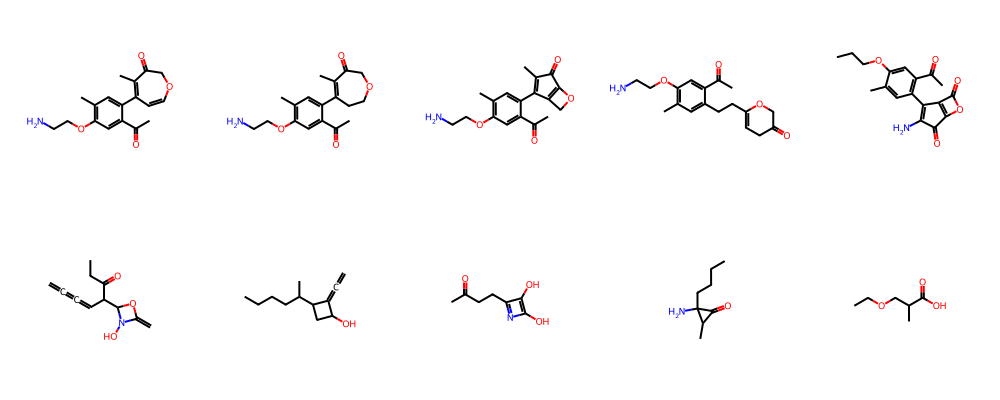

In [164]:
mols = filtered_df['molecule'].tolist()
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200))
display(img)